# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [35]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [36]:
webcam = cv.VideoCapture(0)

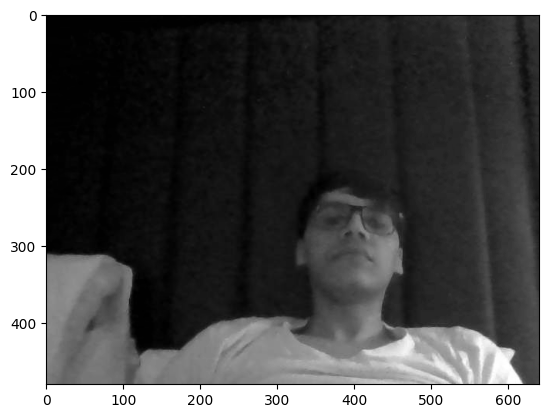

In [37]:
success, frame = webcam.read()
if success:
    grayscale = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    plt.imshow(grayscale, cmap='gray')
    plt.plot()

In [38]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [39]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [40]:
# rescale frame for faster computation
setResLiveVideo(webcam, 400)

In [41]:
def calc_area(img: np.ndarray):
    return np.count_nonzero(img)

In [42]:
def find_centroid(img: np.ndarray):
    area = calc_area(img)
    # calculate the first moment
    m10 = 0
    m01 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m10 += i
                m01 += j
    # calculate the centroid
    x = m10 / area
    y = m01 / area
    # draw a dot at the centroid
    img = cv.circle(img, (int(y), int(x)), 5, (0, 255, 0), -1)
    return (x, y)

In [43]:
def find_axis_of_least_inertia(img: np.ndarray):
    # calc first moments
    x, y = find_centroid(img)
    # calculate the second moments
    m11 = 0
    m20 = 0
    m02 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m11 += (i - x) * (j - y)
                m20 += (i - x) ** 2
                m02 += (j - y) ** 2
    # calculate the angle of least inertia
    theta = 0.5 * np.arctan2(2 * m11, m20 - m02)
    # draw the angle line with midpoint at centroid
    x1 = int(x + 100 * np.cos(theta))
    y1 = int(y + 100 * np.sin(theta))
    x2 = int(x - 100 * np.cos(theta))
    y2 = int(y - 100 * np.sin(theta))

    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    img = cv.line(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, f'{theta}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    cv.imshow("Angle of Least Inertia", img)

    # rotate such that the line of least inertia is horizontally flat
    (rows, cols, _) = img.shape
    M = cv.getRotationMatrix2D((cols/2, rows/2), -math.degrees(theta), 1)
    img = cv.warpAffine(img, M, (cols, rows))
    cv.imshow("Post rotation", img)

    print(f'Angle of least inertia: {theta} {math.degrees(theta)}')
    return theta

In [44]:
def count_fingers(thres_output):
    # Find contours
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0

    # Get the largest contour
    contour = max(contours, key=cv.contourArea)

    # Find the convex hull and the convexity defects
    hull = cv.convexHull(contour, returnPoints=False)
    defects = cv.convexityDefects(contour, hull)

    if defects is None:
        return 0

    # Count the defects (number of fingers)
    count = 0
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(contour[s][0])
        end = tuple(contour[e][0])
        far = tuple(contour[f][0])

        # Use triangle similarity to estimate whether the defect is between fingers
        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))

        # If the angle is less than 100 degrees, it's likely a finger
        if angle < np.deg2rad(100) / 2:
            count += 1

    return count

In [45]:
while True:
    success, orig_frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    cv.imshow("Original", orig_frame)

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    hsv = cv.cvtColor(orig_frame, cv.COLOR_BGR2HSV)
    ycrcb = cv.cvtColor(orig_frame, cv.COLOR_BGR2YCrCb)

    # Define the thresholds for HSV color space
    lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
    upper_hsv = np.array([17, 170, 255], dtype=np.uint8)

    # Define the thresholds for YCrCb color space
    lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
    upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)

    # Create masks for each color space
    mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
    mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # Combine the masks
    mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)

    # Apply the combined mask to the original frame
    frame = cv.bitwise_and(orig_frame, orig_frame, mask=mask_combined)

    # Display the masked video
    cv.imshow("Masked", frame)

    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    #cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    if len(contours) == 0:
        continue

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    theta = find_axis_of_least_inertia(thres_output)

    finger_count = count_fingers(thres_output)
    cv.putText(orig_frame, f'Fingers: {finger_count}', (10, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    cv.imshow("Finger Count", orig_frame)

    #cv.imshow("Video 1", thres_output)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

Angle of least inertia: 1.4981916665117607 85.8400593927952
Angle of least inertia: -1.4963123250951684 -85.73238106136033
Angle of least inertia: 1.1767811340095276 67.42459238936488
Angle of least inertia: -1.5458434856598204 -88.5703075160997
Angle of least inertia: -1.245909587422171 -71.38536101417608
Angle of least inertia: 0.7204363833464862 41.277964173422724
Angle of least inertia: -0.6975426836248355 -39.966251801932316
Angle of least inertia: -1.4504977342482945 -83.10739836571577
Angle of least inertia: 0.9864989033468732 56.52222365605996
Angle of least inertia: 0.12672559124579405 7.260841534684011
Angle of least inertia: -0.8828694621900234 -50.58469404447315
Angle of least inertia: 0.0 0.0
Angle of least inertia: 0.0 0.0
Angle of least inertia: -0.05337558227485368 -3.0581955934024014
Angle of least inertia: 1.4910287581241 85.42965497314339
Angle of least inertia: 1.5276512428624873 87.52796878393525
Angle of least inertia: 1.369224425511563 78.45078078803733
Angle of 

KeyboardInterrupt: 